<a href="https://colab.research.google.com/github/amirnugroho/UAS_DeepLearning/blob/main/5_PCA_(NASA_FIRMS_MODIS)_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/.config/default_configs.db
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/config_sentinel
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/.last_opt_in_prompt.yaml
/content/.config/gce
/content/.config/active_config
/content/.config/logs/2025.08.13/13.41.05.763189.log
/content/.config/logs/2025.08.13/13.41.34.546254.log
/content/.config/logs/2025.08.13/13.41.58.444013.log
/content/.config/logs/2025.08.13/13.41.59.127735.log
/content/.config/logs/2025.08.13/13.41.43.478751.log
/content/.config/logs/2025.08.13/13.41.49.317369.log
/content/.config/configurations/config_default
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_train.csv


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23542 entries, 0 to 23541
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    23542 non-null  float64
 1   longitude   23542 non-null  float64
 2   brightness  23542 non-null  float64
 3   scan        23542 non-null  float64
 4   track       23542 non-null  float64
 5   acq_date    23542 non-null  object 
 6   acq_time    23542 non-null  int64  
 7   satellite   23542 non-null  object 
 8   instrument  23542 non-null  object 
 9   confidence  23542 non-null  int64  
 10  version     23542 non-null  float64
 11  bright_t31  23542 non-null  float64
 12  frp         23542 non-null  float64
 13  daynight    23542 non-null  object 
 14  type        23542 non-null  int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 2.7+ MB
None

Basic Statistics:
            latitude     longitude   brightness          scan         track  \
count   

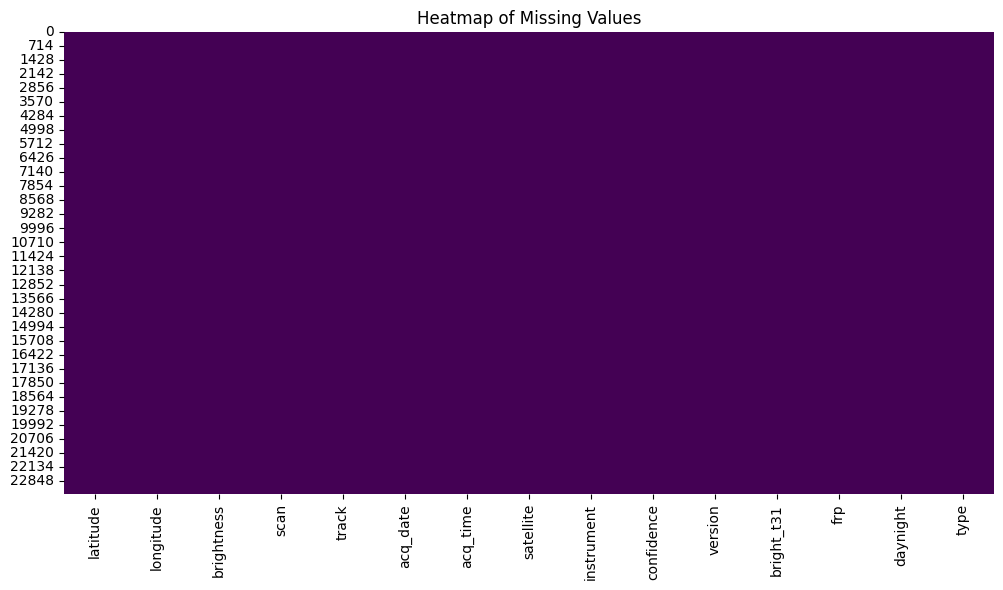

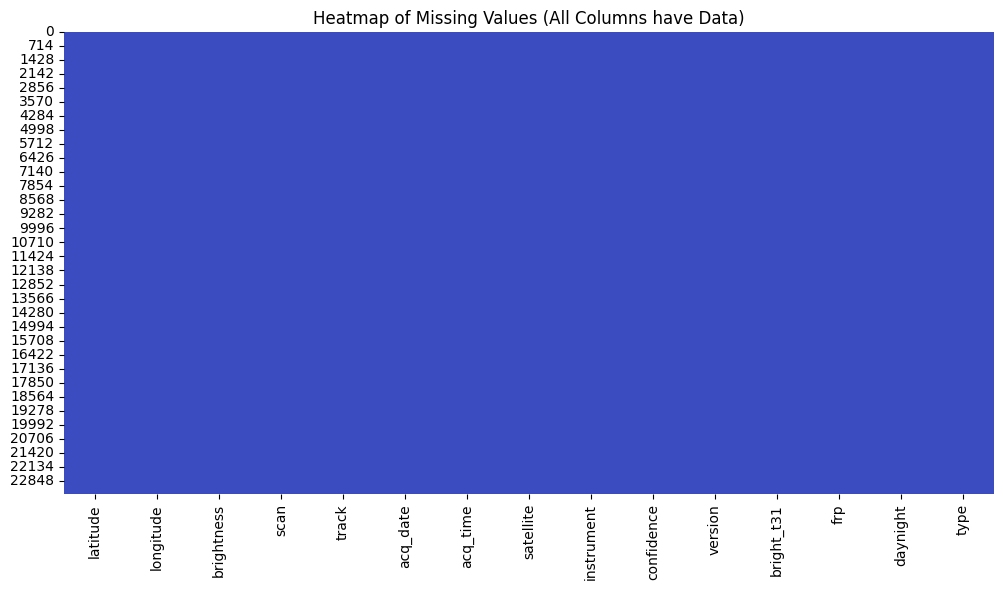


Missing Values after cleaning:
latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64


In [3]:
# Load the dataset
df = pd.read_csv('/content/modis_2024_Indonesia.csv')

# 1. Basic Information
print("Dataset Information:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe(include='all'))

# 2. Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

# Visualizing Missing Values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values")
plt.show()

# 3. Numerical Columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
numerical_columns

# 4. Categorical Columns
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns


# Or drop rows/columns with too many missing values
df_cleaned = df.dropna(thresh=0.5*len(df), axis=1)  # Keep columns with at least 80% data
df_cleaned = df_cleaned.ffill().bfill()
df_cleaned.head()

# Visualizing Missing Values
plt.figure(figsize=(12, 6))
sns.heatmap(df_cleaned.isnull(), cbar=False, cmap='coolwarm')
plt.title("Heatmap of Missing Values (All Columns have Data)")
plt.show()

# Check for Missing Values
print("\nMissing Values after cleaning:")
print(df_cleaned.isnull().sum())

In [4]:
import numpy as np

# Check for invalid values
invalid_values = df_cleaned.isin([np.inf, -np.inf]).sum()
print("Columns with invalid values (inf or -inf):")
print(invalid_values[invalid_values > 0])

Columns with invalid values (inf or -inf):
Series([], dtype: int64)


In [5]:
# Replace inf and -inf with NaN
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values if needed
df_cleaned.fillna(0, inplace=True)  # Replace NaN with 0, or use another strategy

In [6]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Generate the overview
overview = {
    "Shape": df_cleaned.shape,
    "Columns": df_cleaned.columns.tolist(),
    "Data Types": df_cleaned.dtypes,
    "Missing Values": df_cleaned.isnull().sum(),
    "Summary Statistics": df_cleaned.describe(include="all")
}

print(overview)

{'Shape': (23542, 15), 'Columns': ['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'type'], 'Data Types': latitude      float64
longitude     float64
brightness    float64
scan          float64
track         float64
acq_date       object
acq_time        int64
satellite      object
instrument     object
confidence      int64
version       float64
bright_t31    float64
frp           float64
daynight       object
type            int64
dtype: object, 'Missing Values': latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64, 'Summary Statistics':             latitude     longitude   brightness          scan         track  \
count   23542.000000  23542.000000  23542.00000  23542.0000

In [7]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Dataset Info
# 1. Feature Engineering: Extract date features
df_cleaned['acq_date'] = pd.to_datetime(df_cleaned['acq_date'])
df_cleaned['acq_day'] = df_cleaned['acq_date'].dt.day
df_cleaned['acq_month'] = df_cleaned['acq_date'].dt.month
df_cleaned['acq_year'] = df_cleaned['acq_date'].dt.year

# 2. Define features and target
numerical_features = ['latitude', 'longitude', 'brightness', 'scan', 'track',
                      'acq_time', 'confidence', 'bright_t31', 'acq_day', 'acq_month', 'acq_year']
numerical_data = df_cleaned[numerical_features]

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Apply PCA
pca = PCA(n_components=2)  # Choose 2 components for visualization
pca_results = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])

# Add the PCA results back to the original dataset
df_pca = pd.concat([df, pca_df], axis=1)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Output the results
print("Explained Variance Ratio:", explained_variance)
print(df_pca.head())

Explained Variance Ratio: [0.24195602 0.16916849]
   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0   -3.2651   114.9702       311.4   1.0    1.0  2024-01-01       214   
1   -1.8920   115.8655       305.4   1.0    1.0  2024-01-01       214   
2   -2.5788   121.3839       330.2   2.2    1.4  2024-01-01       214   
3   -8.2804   123.4017       310.9   4.0    1.9  2024-01-01       216   
4   -8.2846   123.4369       311.7   4.0    1.9  2024-01-01       216   

  satellite instrument  confidence  version  bright_t31   frp daynight  type  \
0     Terra      MODIS          59    61.03       285.7   6.9        D     0   
1     Terra      MODIS          36    61.03       276.5   3.7        D     2   
2     Terra      MODIS          85    61.03       292.2  82.2        D     2   
3     Terra      MODIS           0    61.03       293.6  47.4        D     0   
4     Terra      MODIS           0    61.03       293.8  52.1        D     0   

        PC1       PC2  
0  0.2

In [8]:
loadings = pd.DataFrame(
    pca.components_,
    columns=numerical_features,
    index=['PC1', 'PC2']
)
print(loadings)

     latitude  longitude  brightness      scan     track  acq_time  \
PC1  0.170493  -0.112473   -0.368362  0.516131  0.519809  0.168275   
PC2  0.514791  -0.500745    0.001160 -0.283552 -0.278509  0.396324   

     confidence  bright_t31   acq_day  acq_month  acq_year  
PC1   -0.244711   -0.419146  0.064900  -0.133803       0.0  
PC2    0.249064   -0.278904  0.037584  -0.167238       0.0  


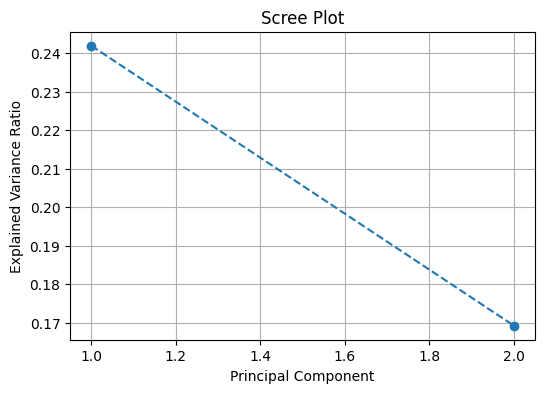

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

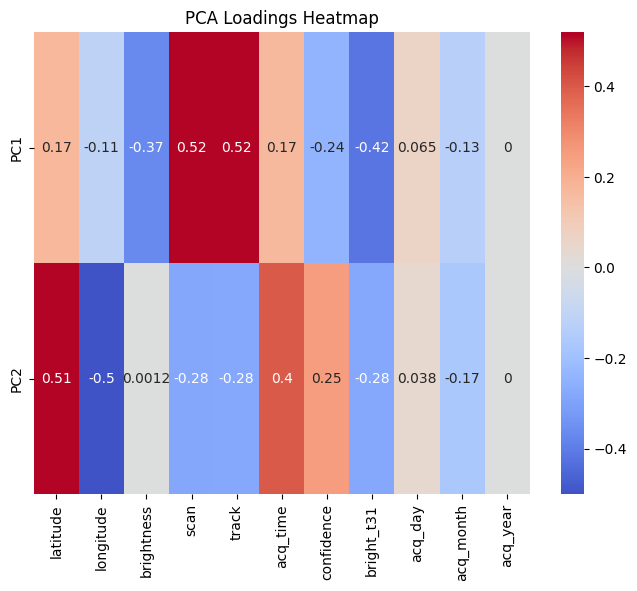

In [10]:
import seaborn as sns

loadings = pd.DataFrame(
    pca.components_,
    columns=numerical_features,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings Heatmap')
plt.show()

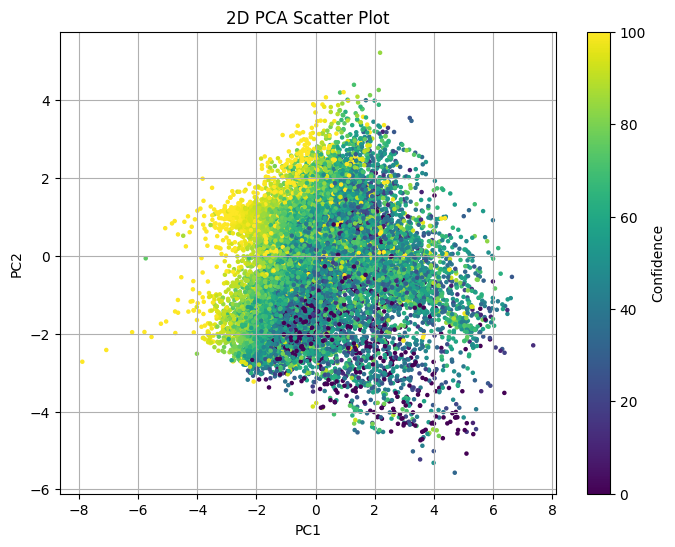

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=df_cleaned['confidence'], cmap='viridis', s=5)
plt.colorbar(label='Confidence')
plt.title('2D PCA Scatter Plot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

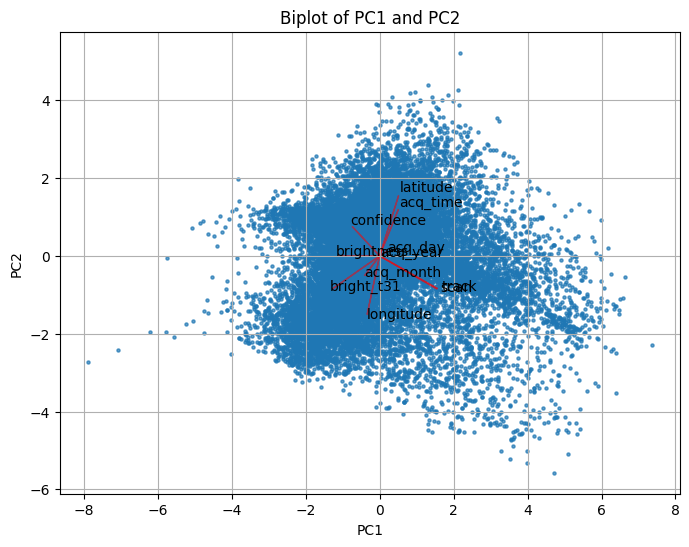

In [12]:
plt.figure(figsize=(8, 6))

# Scatter plot of the data
plt.scatter(pca_results[:, 0], pca_results[:, 1], s=5, alpha=0.7)

# Add arrows for loadings
for i, feature in enumerate(numerical_features):
    plt.arrow(0, 0, loadings.iloc[0, i] * 3, loadings.iloc[1, i] * 3, color='red', alpha=0.5)
    plt.text(loadings.iloc[0, i] * 3.2, loadings.iloc[1, i] * 3.2, feature, color='black')

plt.title('Biplot of PC1 and PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

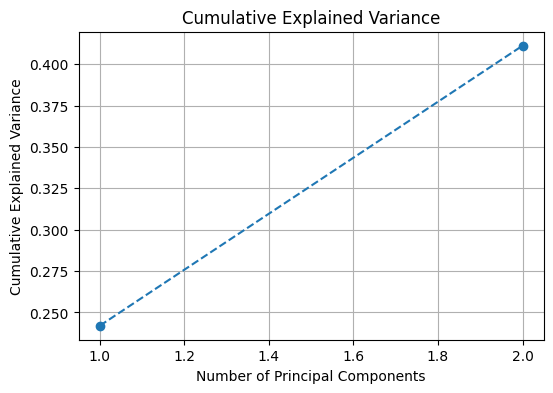

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()